# Experimenting with Cleaning, Clustering & Summarization Pipelines

### To do (technical)
- Implement date windows on my corpus loader function

In [50]:
import os
import re
import json
import hdbscan

import numpy as np
import pandas as pd
import networkx as nx

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from lib.helper import *
import lib.embedding_models as reps

from importlib import reload

%matplotlib inline

In [2]:
# Should be same path for all my PC's, it's where each scrape goes as a separate json file.
storage_path = "C:/Users/Martin/Dropbox/news_crow/scrape_results"

# "bing" is targeted news search corpus, "RSS" is from specific world and local news feeds.
corpus_type = "bing"

## 0.  Build Corpus

The corpus is being scraped by the "run_news_scrapes.py" script (and windows task scheduler) every 12 hours, a bit past midday and a bit past midnight.

The "bing" corpus are news titles and text extracts gotten from the bing news search API, using a few Home Office - related keywords.

The "RSS" corpus is plugged directly into a number of RSS feeds for world news sites and local british news sites, with no filters for news story types or subjects applied.

### First, get a list of all the news dumps created so far

In [3]:
corpus = corpus_loader(storage_path, corpus_type)

Total files: 36
Loading file: bing_corpus_2019-09-05_2135.json
Loading file: bing_corpus_2019-09-06_0019.json
Loading file: bing_corpus_2019-09-06_1221.json
Loading file: bing_corpus_2019-09-07_0019.json
Loading file: bing_corpus_2019-09-07_1221.json
Loading file: bing_corpus_2019-09-08_0019.json
Loading file: bing_corpus_2019-09-08_1221.json
Loading file: bing_corpus_2019-09-09_0019.json
Loading file: bing_corpus_2019-09-09_1221.json
Loading file: bing_corpus_2019-09-10_0019.json
Loading file: bing_corpus_2019-09-10_1221.json
Loading file: bing_corpus_2019-09-11_0019.json
Loading file: bing_corpus_2019-09-11_1221.json
Loading file: bing_corpus_2019-09-12_0019.json
Loading file: bing_corpus_2019-09-12_1221.json
Loading file: bing_corpus_2019-09-13_0019.json
Loading file: bing_corpus_2019-09-13_1221.json
Loading file: bing_corpus_2019-09-14_0019.json
Loading file: bing_corpus_2019-09-14_1221.json
Loading file: bing_corpus_2019-09-15_0019.json
Loading file: bing_corpus_2019-09-15_2059.js

In [4]:
corpus.head()

,date,link,origin,retrieval_timestamp,source_url,summary,title
0,2019-09-05T17:32:00.0000000Z,https://www.desmoinesregister.com/story/opinio...,bing_news_api,2019-09-05 21:35:05.105002,www.desmoinesregister.com,<b>Immigration</b> raids are as devastating to...,<b>Immigration</b> raids are as devastating to...
1,2019-09-05T20:06:00.0000000Z,https://www.philstar.com/the-freeman/cebu-news...,bing_news_api,2019-09-05 21:35:05.105002,www.philstar.com,"CEBU, Philippines — The Department of Justice ...",<b>Immigration</b> told to monitor convicts: L...
2,2019-09-05T17:21:00.0000000Z,https://www.irishtimes.com/news/crime-and-law/...,bing_news_api,2019-09-05 21:35:05.106001,www.irishtimes.com,Three members of an organised crime gang were ...,Three people jailed for assisting illegal <b>i...
3,2019-09-05T20:12:00.0000000Z,https://www.correctionsone.com/immigration-det...,bing_news_api,2019-09-05 21:35:05.106001,www.correctionsone.com,"NATCHEZ, Miss. — A privately run prison in Mis...",<b>Immigration</b> agency sets new contract wi...
4,2019-09-05T19:27:00.0000000Z,https://www.nzherald.co.nz/nz/news/article.cfm...,bing_news_api,2019-09-05 21:35:05.106001,www.nzherald.co.nz,A licensed <b>immigration</b> adviser has been...,<b>Immigration</b> adviser censured and fined ...


## 1. Clean Text

By default, I'm not going to clean out all punctuation because I think it informs the POS tagger to some degree.

In [5]:
corpus['clean_text'] = corpus[['title', 'summary']].apply(lambda x: clean_text('.  '.join(x)), axis=1)

In [6]:
# Filter to only the .uk vendors
corpus = corpus[corpus['link'].str.contains(".uk/")]

In [7]:
corpus = corpus.drop_duplicates("clean_text")

In [8]:
corpus['clean_text'].head()

14    Government announces immigration plans for no ...
16    Home Secretary Priti Patel admits No Deal Brex...
28    Student film on immigration focuses on those m...
30    No deal immigration arrangements for EU citize...
31    AP EXPLAINS: What changed in 0 days of immigra...
Name: clean_text, dtype: object

In [9]:
corpus.shape

(569, 8)

## 2.  Build Text Model (Representation, eg; word2vec, entities list...)

- Trying with the world corpus and with the bing corpus, neither worked with InferSent.  Suspect the problem lies in the PCA step, which may not be working well on this high-dimensional (vector length = 4096) form.
- Summed keywords works rather better with the world corpus.
- Summed keywords still fail the bing/home office corpus, giving me a cluster about "immigration" and a cluster for the American Supreme Court.

In [ ]:
# Windows didn't play nicely with the vector datasets, Some obscure encoding problem (python in Conda
# kept trying to decode using cp1252 regardless of whatever other options I specified!)
# Solution; rewrite file and drop any characters the Windows encoder refuses to recognise.
# I shouldn't loose too much info.
#with open('./lib/InferSent/dataset/fastText/crawl-300d-2M.vec', "r", encoding="cp1252", errors="ignore") as infile:
#    with open('./lib/InferSent/dataset/fastText/crawl-300d-2M_win.vec', "wb") as outfile:
#        for line in infile:
#            outfile.write(line.encode('cp1252'))

In [ ]:
#infersent = reps.InferSentModel(list(corpus['clean_text']),
#                                list(corpus['clean_text']),
#                                W2V_PATH = './lib/InferSent/dataset/fastText/crawl-300d-2M_win.vec')
#
#embeddings = infersent.get_embeddings()

In [ ]:
# Whereas this worked first time!
glove = reps.GloveWordModel(list(corpus['clean_text']), list(corpus['clean_text']))

embeddings = glove.get_embeddings()

In [ ]:
# Turn that into a DF for me
embeddings_df = pd.DataFrame({"clean_text": list(embeddings.keys()),
                              "embeddings": list(embeddings.values())})

## 3. Cluster Text

This is the part where the pipelines get a little more experimental

In [ ]:
embeddings_array = np.vstack(embeddings_df['embeddings'])

In [ ]:
# First, PCA the data
new_dims = 20

pca = PCA(n_components=20, svd_solver='full')

embeddings_pca = pca.fit_transform(embeddings_array)

In [ ]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_) 

In [ ]:
clusterer = hdbscan.HDBSCAN()

In [ ]:
clusterer.fit(embeddings_array)

In [ ]:
pd.unique(clusterer.labels_)

# Clustering using Entity Detection And Network Analytics

This doesn't resolve very well for Bing, because there's a whole bunch of keywords from the original searches in there.  Suspect that's got a lot to do with the failure of the other methods too.  For the network analytics method I'm going to try removing the keywords from the table first.

In [25]:
with open("C:/Users/Martin/Dropbox/news_crow/scrape_settings.json", "r") as f:
    scrape_config = json.load(f)

search_terms = scrape_config['search_list']
search_terms = re.sub(r"[^0-9A-Za-z ]", "", " ".join(search_terms)).lower().split()
search_terms = set(search_terms)

In [26]:
search_terms

{'abuse',
 'border',
 'child',
 'domestic',
 'enforcement',
 'force',
 'home',
 'immigration',
 'international',
 'office',
 'patel',
 'priti',
 'secretary',
 'students',
 'uk',
 'windrush'}

In [27]:
test = reps.NounAdjacencyModel(corpus['clean_text'], corpus['clean_text'])

In [28]:
nouns_df = test.table.copy()
nouns_df.head()

,thicketford,danielle,ice,metropolitan,paediatrician,parker,act,usa,davies,sheikh,...,morrissey,generation,piccadilly,highlights,hertfordshire,domestic,funnell,women,afghan,ets
clean_text,,,,,,,,,,,,,,,,,,,,,
"Government announces immigration plans for no deal Brexit. New border controls that will make it harder for serious criminals to enter the UK will be introduced in the event of a no deal Brexit, the government has announced today (4 September). In a move signalling the end of free movement in its current form, a ...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Home Secretary Priti Patel admits No Deal Brexit wouldn’t end unregulated EU immigration until 2021. PRITI PATEL tonight conceded unlimited EU immigration will all-but remain in place until 2021 in a No Deal. Despite promising tougher criminal checks on migrants from October 1, the Home Office said EU citizens would be allowed unfettered access to the UK ...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Student film on immigration focuses on those making district their home. A STUDENT from Bradford has helped create a short film on immigration, featuring interviews with three people who have made the district their home. Ruby Blake, 22, who studied film and TV production at Northumbria University, was inspired to make the ...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
No deal immigration arrangements for EU citizens moving to the UK after Brexit. The United Kingdom will be leaving the European Union on 1 October 201. This paper sets out the immigration arrangements that will apply to EU citizens and their family members who are moving to the UK after Brexit on 1 October 201 in the event that ...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"AP EXPLAINS: What changed in 0 days of immigration accord?. MEXICO CITY (AP) - Since last year;s caravans of Central American migrants began reaching the U.S. border, the Trump administration had been increasing pressure on Mexico President Andrés Manuel López Obrador to stop the flow of migrants. But it was the ...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
print(nouns_df.shape)
for each in search_terms:
    try:
        nouns_df = nouns_df.drop(each, axis="columns")
    except:
        pass

print(nouns_df.shape)

embeddings = np.asarray(nouns_df)
adjacency = np.dot(embeddings, embeddings.T)
print(np.max(adjacency))

(569, 1377)
(569, 1362)


## Actually; the below is just the long way around to get the PageRank algorithm

Except that I've accounted for edge weights less well.  Oh well, live and learn... :)

In [145]:
upper = 100
lower = 1
G = nx.Graph()
rows, cols = np.where((upper >= adjacency) & (adjacency >= lower))
weights = [float(adjacency[rows[i], cols[i]]) for i in range(len(rows))]
edges = zip(rows.tolist(), cols.tolist(), weights)
G.add_weighted_edges_from(edges)

In [151]:
net_degrees = dict(nx.degree(G))
degree_df = pd.DataFrame({"node": list(net_degrees.keys()), "degree": list(net_degrees.values())})
degree_df = degree_df.sort_values("degree", ascending=False)

for index, row in degree_df.head(10).iterrows():
    article = nouns_df.reset_index().iloc[index]
    print(row['degree'], article['clean_text'])

190 Home Secretary visits the police hubs leading Brexit preparations. Home Secretary Priti Patel today (Thursday 8 August) visited 2 policing hubs that are at the heart of law enforcement’s preparation for the UK’s exit from the European Union on 1 October. The International Crime and Coordination Centre (ICCC) went ...
181 Hidden in the Brexit chaos, the Tories’ grotesque immigration policy has crashed and burned. It’s been easy to overlook in all the headlines about the coup and blocking a no-deal Brexit, but amidst the chaos the Tories have been forced to make a screeching U-turn on their immigration policy. The prime minister and his home secretary claimed they ...
174 News Daily: Home Office ad ban and Bury FC expelled from Football League. In April, a government radio advert told EU citizens wanting to stay in the UK after Brexit: quot;All you need to apply is your passport or ID card and to complete an online form.quot; But many applicants - around a quarter of adult cases, it 

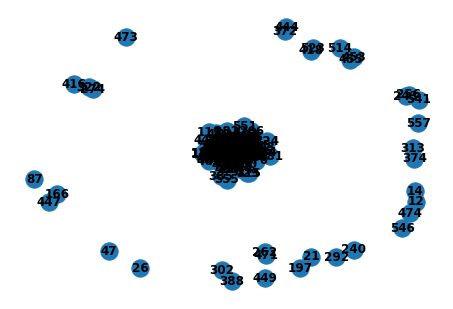

In [152]:
G_plot = nx.petersen_graph()
#plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
#plt.subplot(122)
#nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')